# carbon_kh Test Suite

This is a simple convergence study illustrating the behavior of different forms of the energy equation

## Prelude

In [1]:
import functools
import glob
import itertools
import os

In [2]:
import numpy as np
from scipy.interpolate import interp1d

In [3]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
plt.style.use('mesa.mplstyle')

In [4]:
import mesa_reader as mr

## Runs

These convergence study runs can be done by modifying the inlist_carbon_kh to load the variable resolution/equation inlists

      ! for convergence studies
      read_extra_controls_inlist(2) = .true.
      extra_controls_inlist_name(2)= 'inlist_resolution'

      read_extra_controls_inlist(3) = .true.
      extra_controls_inlist_name(3)= 'inlist_equations'

and then by using the included script ``./rnall``.

In [5]:
class RunSet:
    
    @functools.lru_cache
    def history(self, identifier):
        return mr.MesaData(os.path.join(self.prefix, f'{self.name}-{identifier}.data'))
    
    def final_profile(self, identifier):
        return mr.MesaData(os.path.join(self.prefix, f'{self.name}-{identifier}.profile'), file_type='log')
    
    def __init__(self, prefix, name, label):
        self.prefix = prefix
        self.name = name
        self.label = label

In [6]:
resolutions = ['lr', 'mr', 'hr', 'ur']
res_names = ['low', 'mid', 'high', 'ultra']
styles = ['dotted', 'dashdot', 'dashed', 'solid']
widths = [0.5, 0.5, 0.5, 0.5]
res_props = {r:{'linestyle': s, 'linewidth': w} for r,s,w in zip(resolutions,styles, widths)}

In [7]:
prefix = '../LOGS/'
dedt_total = RunSet(prefix, 'dedt_total', 'dedt (total energy)')
eps_grav = RunSet(prefix, 'eps_grav', r'eps\_grav (end of step)')
eps_grav_center = RunSet(prefix, 'eps_grav_future', r'eps\_grav (centered)')
sets = [dedt_total, eps_grav, eps_grav_center]
colors = ['C0', 'C1', 'C2', 'C3']
set_props = {s.name:{'color': c} for s,c in zip(sets,colors)}

In [8]:
def add_legend():
    """Draw a legend showing equations and resolutions"""
    custom_lines = [Line2D([0], [0], color=c) for c in colors]
    fig.add_artist(ax.legend(custom_lines, [f.label for f in sets], loc=4))

    custom_lines = [Line2D([0], [0], color='black', **res_props[r]) for r in res_props]
    fig.add_artist(ax.legend(custom_lines, res_names, loc=2))

In [9]:
def plot_values(xfac=1, yfac=1):
    """Plot a history or profile quantities"""
    for r in resolutions[:-1]:
        for f in sets:
            if file_type.startswith('h'):
                d = f.history(r)
            elif file_type.startswith('p'):
                d = f.final_profile(r)
            else:
                raise
            xs = xfac * getattr(d, xname)
            ys = yfac * getattr(d, yname)
            ax.plot(xs, ys, **res_props[r], **set_props[f.name])

In [10]:
def plot_reference_differences(rel_diff=False):
    """Draw a grey band showing the range of reference solutions"""
    r = resolutions[-1]
    for f1, f2 in itertools.combinations(sets, 2):
        if file_type.startswith('h'):
            dref = f1.history(r)
            d = f2.history(r)
        elif file_type.startswith('p'):
            dref = f1.final_profile(r)
            d = f2.final_profile(r)
        else:
            raise
        xref = getattr(dref, xname)
        yref = getattr(dref, yname)
        xs = getattr(d, xname)
        ys = getattr(d, yname)
        yx = interp1d(xs, ys, fill_value="extrapolate")
        if rel_diff:
            diff = np.abs((yx(xref) - yref)/yx(xref))
        else:
            diff = np.abs(yx(xref) - yref)
        ax.fill_between(xref, 0, diff, color='lightgrey')

In [11]:
def plot_differences(rel_diff=False):
    """Plot differences between runs and reference for a given quantity"""
    xref = getattr(dref, xname)
    yref = getattr(dref, yname)
    yx = interp1d(xref, yref, fill_value="extrapolate")
    
    for r in resolutions[:-1]:
        for f in sets:
            if file_type.startswith('h'):
                d = f.history(r)
            elif file_type.startswith('p'):
                d = f.final_profile(r)
            else:
                raise
            xs = getattr(d, xname)
            ys = getattr(d, yname)
            if rel_diff:
                diff = np.abs((yx(xs) - ys)/yx(xs))
            else:
                diff = np.abs(yx(xs) - ys)
            ax.plot(xs, diff, **res_props[r], **set_props[f.name])

## History comparison

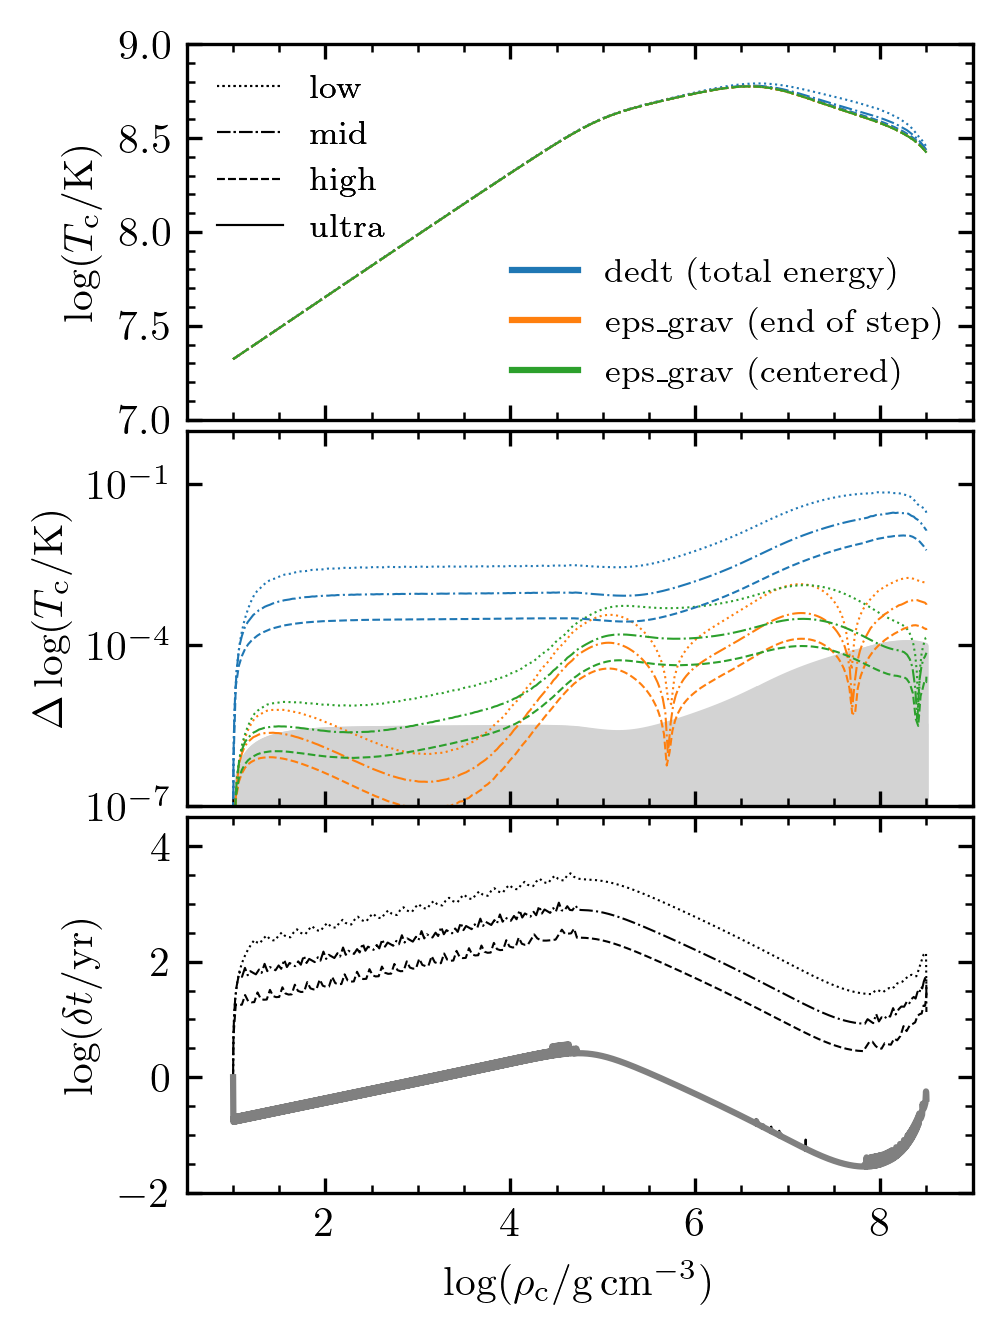

In [12]:
fig, axs = plt.subplots(3, sharex=True)

### Top panel

ax = axs[0]

file_type = 'history'
xname = 'log_center_Rho'
yname = 'log_center_T'
plot_values()
add_legend()

ax.set_ylabel(r'$\log(T_{\rm c}/\rm K)$')
ax.set_ylim(7, 9)

### Middle panel

ax = axs[1]

# first show level at which ultra-res runs disagree
plot_reference_differences()

# use ultra time-centered eps_grav as reference
dref = eps_grav_center.history('ur')
plot_differences()

ax.set_ylabel(r'$\Delta \log(T_{\rm c}/\rm K)$')
ax.set_ylim(1e-7, 1)
ax.set_yscale('log')

### Bottom panel

ax = axs[2]

for r in resolutions:
    for f in sets[0:1]: # all the same
        d = f.history(r)
        xs = d.log_center_Rho
        ax.plot(xs, d.log_dt, **res_props[r], color='black')

dref = eps_grav_center.history('ur')
ax.plot(dref.log_center_Rho, dref.log_dt, color='grey', ls='solid')
        

ax.set_xlim(0.5, 9)
ax.set_xlabel(r'$\log(\rho_{\rm c}/\rm g\,cm^{-3})$')

ax.set_ylabel(r'$\log(\delta t/\rm yr)$')
ax.set_ylim(-2, 4.5)

fig.set_size_inches(3.38, 1.5*3.38)
fig.subplots_adjust(hspace=0.03)
fig.savefig('carbon_kh_Rhoc-Tc_history_with_dt.png')

## Profile comparison

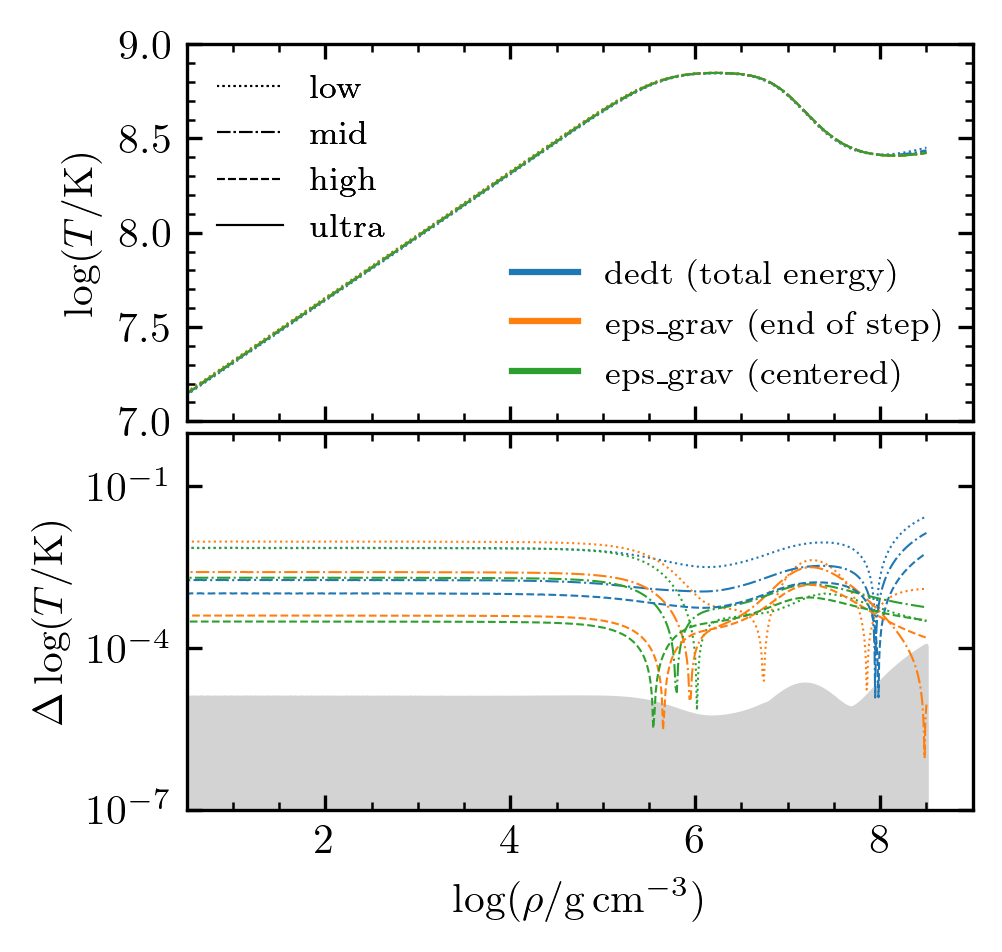

In [13]:
fig, axs = plt.subplots(2, sharex=True)

### Top panel

ax = axs[0]

file_type = 'profile'
xname = 'logRho'
yname = 'logT'
plot_values()
add_legend()

ax.set_ylabel(r'$\log(T/\rm K)$')
ax.set_ylim(7, 9)

### Bottom panel

ax = axs[1]

# first show level at which high-res runs disagree
plot_reference_differences()

dref = eps_grav_center.final_profile('ur')
plot_differences()

ax.set_ylabel(r'$\Delta \log(T/\rm K)$')
ax.set_ylim(1e-7, 1)
ax.set_yscale('log')

ax.set_xlim(0.5, 9)
ax.set_xlabel(r'$\log(\rho/\rm g\,cm^{-3})$')
fig.set_size_inches(3.38, 1.0*3.38)
fig.subplots_adjust(hspace=0.03)
fig.savefig('carbon_kh_Rho-T_final_profile.png')

## Energy comparision

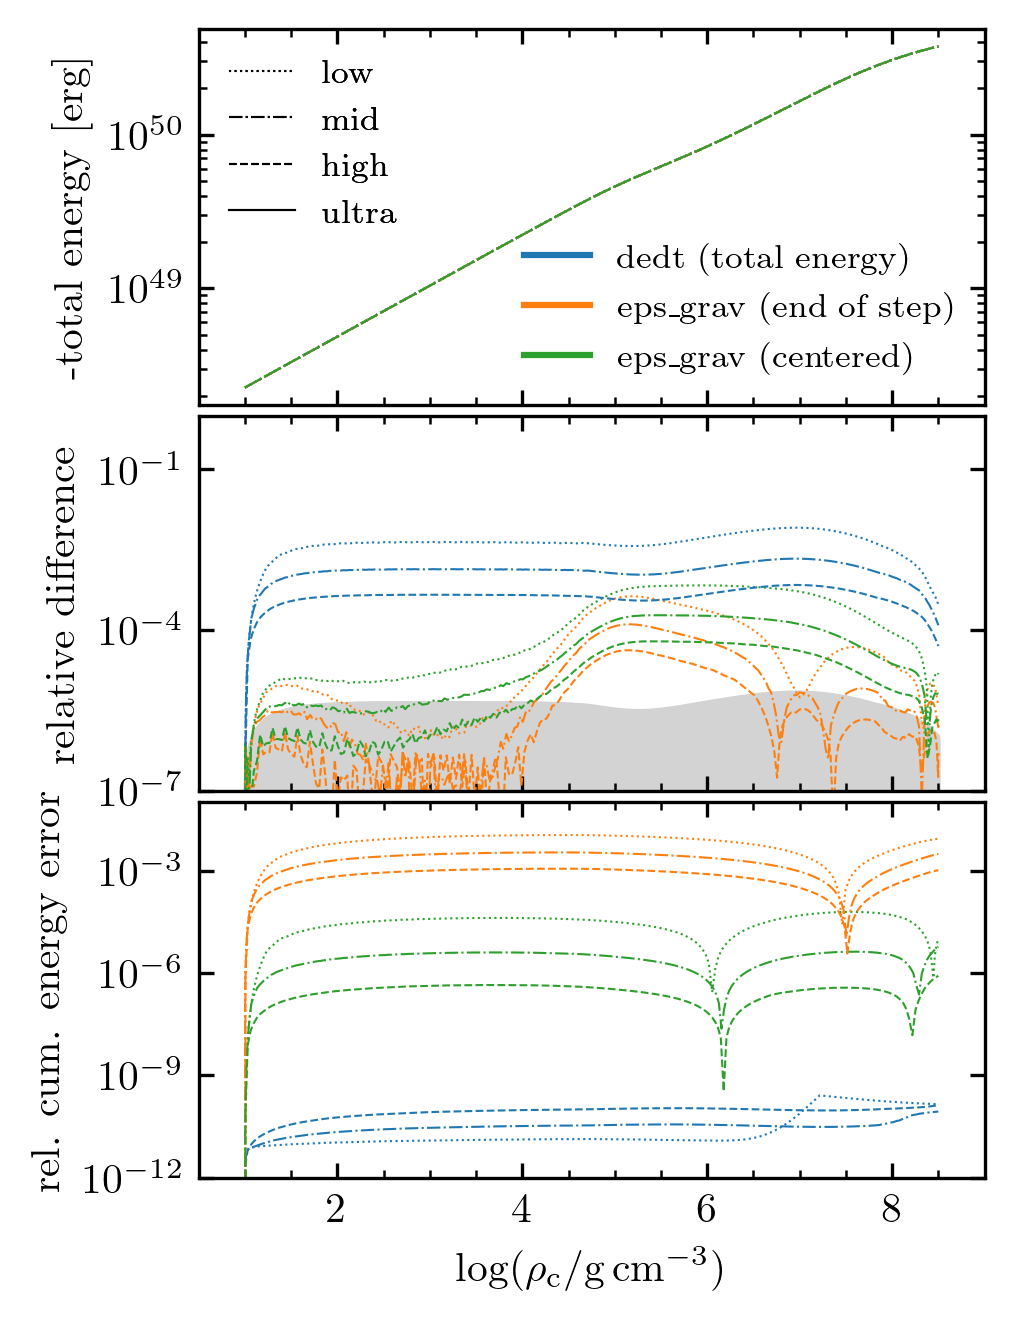

In [14]:
fig, axs = plt.subplots(3, sharex=True)

### Top panel

ax = axs[0]

file_type = 'history'
xname = 'log_center_Rho' #'R'
yname = 'total_energy'
plot_values(yfac=-1)
add_legend()

ax.set_yscale('log')
ax.set_ylabel('-total energy [erg]')

### Middle panel

ax = axs[1]

# first show level at which ultra-res runs disagree
plot_reference_differences(rel_diff=True)

dref = eps_grav_center.history('ur')

plot_differences(rel_diff=True)

ax.set_ylabel(r'relative difference')
ax.set_ylim(1e-7, 1)
ax.set_yscale('log')

### Bottom panel

ax = axs[2]

for r in resolutions[:-1]:
    for f in sets:
        d = f.history(r)
        xs = d.log_center_Rho
        ax.plot(xs, np.abs(d.cumulative_energy_error)/np.abs(d.total_energy), **res_props[r], **set_props[f.name])

ax.set_ylabel('rel. cum. energy error')
ax.set_ylim(1e-12, 1e-1)
ax.set_yscale('log')


ax.set_xlim(0.5, 9)
ax.set_xlabel(r'$\log(\rho_{\rm c}/\rm g\,cm^{-3})$')
fig.set_size_inches(3.38, 1.5*3.38)
fig.subplots_adjust(hspace=0.03)
fig.savefig('carbon_kh_total_energy_history_with_rel_cum_E_err.png')

In [ ]:
def L1_error(dq, dref, xname, yname):
    xq = getattr(d, xname)
    xref = getattr(dref, xname)
    yq = getattr(d, yname)
    yref = getattr(dref, yname)
    f = interp1d(xq, yq, fill_value="extrapolate")
    yerr = np.abs(f(xref) - yref)
    return np.trapz(yerr, xref) / np.trapz(np.ones_like(yerr), xref)